## FNED and FPED Implementation

In [2]:
import pandas as pd
import numpy as np
import math
import os
import random 

#### Read Original Data

In [3]:
df = pd.read_csv("../data/eec/data.csv")

df = df.dropna(subset=["Emotion"])

label = {"joy" : 1, "sadness" : 0, "fear" : 0, "anger" : 0 }

def change_label(text) :
    return label[text]

df["label"] = df["Emotion"].apply(change_label)

df = df.drop(columns=["ID", "Person", "Race", "Emotion", "Emotion word"])

In [4]:
df

,Sentence,Template,Gender,label
0,Alonzo feels angry.,<person subject> feels <emotion word>.,male,0
1,Alonzo feels furious.,<person subject> feels <emotion word>.,male,0
2,Alonzo feels irritated.,<person subject> feels <emotion word>.,male,0
3,Alonzo feels enraged.,<person subject> feels <emotion word>.,male,0
4,Alonzo feels annoyed.,<person subject> feels <emotion word>.,male,0
...,...,...,...,...
8635,The conversation with my mom was funny.,The conversation with <person object> was <emo...,female,1
8636,The conversation with my mom was hilarious.,The conversation with <person object> was <emo...,female,1
8637,The conversation with my mom was amazing.,The conversation with <person object> was <emo...,female,1
8638,The conversation with my mom was wonderful.,The conversation with <person object> was <emo...,female,1


#### Read Prediction Result from the Model

Make sure you set variable `ouput_dir` with the same `output_dir` in the fine-tuning parameter

In [5]:
def read_txt(fpath):
    pred = []
    file = open(fpath)
    lines = file.readlines()
    for l in lines :
        pred.append(int(l))
    file.close()
    
    return pred

In [6]:
output_dir = "biasfinder_eec"

result_dir = "../result/" + output_dir + "/"

path = result_dir + "results_data.txt"

pred = read_txt(path)

print(len(pred))

8400


In [7]:
df["prediction"] = pred
# df["label"] = df[0]

In [8]:
df.head()

,Sentence,Template,Gender,label,prediction
0,Alonzo feels angry.,<person subject> feels <emotion word>.,male,0,0
1,Alonzo feels furious.,<person subject> feels <emotion word>.,male,0,0
2,Alonzo feels irritated.,<person subject> feels <emotion word>.,male,0,0
3,Alonzo feels enraged.,<person subject> feels <emotion word>.,male,0,0
4,Alonzo feels annoyed.,<person subject> feels <emotion word>.,male,0,0


#### Group by Country

In this case, we group by `country`. You can try to group by `gender`.

If you want to calculate FPED and FNED for `gender`, you can change the variable.

In [9]:
dc = df
identifier = "Gender"
dc = df.groupby(identifier)

dc.count()

,Sentence,Template,label,prediction
Gender,,,,
female,4200,4200,4200,4200
male,4200,4200,4200,4200


In [10]:
print(len(dc))

identifiers = []
for k, v in dict(iter(dc)).items() :
    identifiers.append(k)

2


#### Calculate Global Performance

In [11]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

y_test = df["label"]
y_pred = df["prediction"]
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print(cm)

              precision    recall  f1-score   support

           0       0.99      0.69      0.81      6300
           1       0.51      0.97      0.67      2100

    accuracy                           0.76      8400
   macro avg       0.75      0.83      0.74      8400
weighted avg       0.87      0.76      0.77      8400

[[4333 1967]
 [  63 2037]]


#### Calculate Performance for each Group

In [12]:
for k, v in dict(iter(dc)).items() :
    y_test = v["label"]
    y_pred = v["prediction"]
#     print(classification_report(y_test, y_pred))
#     cm = confusion_matrix(y_test, y_pred)
#     print(cm)

#### Implementation

Fundamental Thery about FPR and FNR: 
https://medium.com/datadriveninvestor/confusion-matric-tpr-fpr-fnr-tnr-precision-recall-f1-score-73efa162a25f


Theory on FPED and FNED:
https://research.google/pubs/pub46743/ 

In [13]:
# calculate false positive rate from given consufsion matrix
def calculate_fpr(cm) :
    negative = np.sum(cm[0])
    fp = cm[0][1]
    fpr = fp / negative
    return fpr

# calculate false positive rate from given consufsion matrix
def calculate_fnr(cm) :
    negative = np.sum(cm[0])
    fn = cm[1][0]
    fnr = fn / negative
    return fnr

print(calculate_fpr(cm))
print(calculate_fnr(cm))

0.31222222222222223
0.01


#### Calculate Global FPR and FNR

In [14]:
y_test = df["label"]
y_pred = df["prediction"]
cm = confusion_matrix(y_test, y_pred)
global_fpr = calculate_fpr(cm)
global_fnr = calculate_fnr(cm)
print("global fpr: ", global_fpr)
print("global fnr: ", global_fnr)

global fpr:  0.31222222222222223
global fnr:  0.01


#### Calculate FPR and FNR for each Country

In [15]:
fprs = []
fnrs = []

for k, v in dict(iter(dc)).items() :
    y_test = v["label"]
    y_pred = v["prediction"]
    cm = confusion_matrix(y_test, y_pred)
    fpr = calculate_fpr(cm)
    fnr = calculate_fnr(cm)
    fprs.append(round(fpr, 5))
    fnrs.append(round(fnr, 5))

In [16]:
# !pip install matplotlib --ignore-installed 

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline


dfprs = pd.DataFrame(data={"identifier": identifiers, "FPR":fprs})
dfprs = dfprs.groupby("identifier").sum().sort_values(by=["FPR"],ascending=False)

dfprs.head()

,FPR
identifier,
male,0.31619
female,0.30825


Text(0, 0.5, 'FPR')

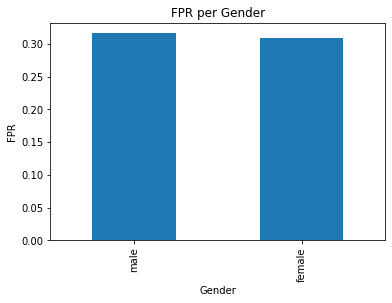

In [18]:
my_plot = dfprs.plot(kind='bar', legend=None, title="FPR per " + identifier)
my_plot.set_xlabel(identifier)
my_plot.set_ylabel("FPR")

In [19]:
dfnrs = pd.DataFrame(data={"identifier": identifiers, "FNR":fnrs})
dfnrs = dfnrs.groupby("identifier").sum().sort_values(by=["FNR"],ascending=False)

dfnrs.head()

,FNR
identifier,
male,0.01016
female,0.00984


Text(0, 0.5, 'FNR')

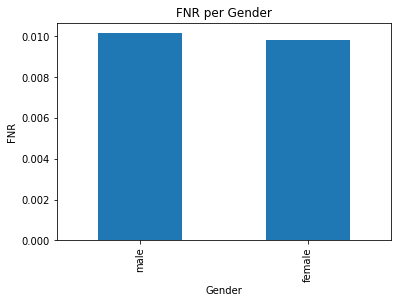

In [20]:
my_plot = dfnrs.plot(kind='bar', legend=None, title="FNR per " + identifier)
my_plot.set_xlabel(identifier)
my_plot.set_ylabel("FNR")

#### Calculate FNED and FPED

In [61]:
fped = 0
fned = 0

for _fpr, _fnr in zip(fprs, fnrs) :
    fped += abs(global_fpr - fpr)
    fned += abs(global_fnr - fnr)

print()
print("FPED: ", fped)
print("FNED: ", fned)


FPED:  0.007619047619047636
FNED:  0.000634920634920634
